# GEOCLIM Parameter Exploration

This notebook takes the 93,600 chemical weathering maps produced during the calibration stage of GEOCLIM, and removes those parameter combinations that do not match measurements of chemical weathering in watersheds around the world.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.notebook import tqdm

from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Functions

In [2]:
def extract_basin_variables(param_nc):
    """
    Get data for each basin in the basin mask.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
    
    Returns
    -------
    basin_model_df : dataframe
        Contains the t(CaMgNaK)/yr/km2 for each basin.
        
    total_CO2_consumption : array
        Total CO2 consumption (mol/yr) for each run.
    """
    n_runs = len(param_nc.variables['parameterization'])
    n_basins = len(basin_data['basin'])
    
    # get area map - units: m2
    area_map = param_nc.variables['land_area'][:,:].data.copy()
    area_map[np.isnan(area_map)] = 0
    area_map[area_map > 1e30] = 0
    
    # storage arrays
    basin_model = np.zeros((n_runs, n_basins))
    total_CO2_consumption = np.zeros(n_runs)
    
    # loop over each parameter run
    for i in tqdm_notebook(range(n_runs), desc='run loop'):
        
        # get CO2 consumption map - units: mol(CaMg)/m2/yr
        weath_map = param_nc.variables['weathering'][i,:,:].data.copy()
        weath_map[np.isnan(weath_map)] = 0
        weath_map[weath_map > 1e30] = 0
        
        # convert CO2 consumption map from mol(CaMg)/m2/yr to mol(CaMg)/yr
        weath_total_map = weath_map * area_map
        
        # get total CO2 consumption
        total_CO2_consumption[i] = np.nansum(weath_total_map)         
        
        # loop over each basin
        for j in range(n_basins):
            
            # pull out the basin mask - units are in m2
            if basin_data['basin'][j] in basin_mask_1.variables.keys():
                this_basin_mask = basin_mask_1.variables[basin_data['basin'][j]][:,:].data.copy()
            elif basin_data['basin'][j] in basin_mask_2.variables.keys():
                this_basin_mask = basin_mask_2.variables[basin_data['basin'][j]][:,:].data.copy()
            else:
                print('!! WARNING !! {} not in the basin masks!'.format(basin_data['basin'][j]))
                break
                
            this_basin_mask[np.isnan(this_basin_mask)] = 0
            this_basin_mask[this_basin_mask < 0] = 0
                
            # sum and store - mol(CaMg)/yr/m2
            basin_model[i, j] = np.nansum(weath_map*this_basin_mask) / np.nansum(this_basin_mask)
            
    # store as a dataframe        
    basin_model_df = pd.DataFrame(columns=basin_data['basin'], data=basin_model)
    
    # convert from mol(CaMg)/yr/m2 to t(CaMgNaK)/yr/km2
    for i in range(n_basins):
        Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
        if len(Gaillardet1999a_row.index)!=0:
            mol_kg = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]/\
                     Gaillardet1999a_row['silicates_Cation_sil'].values[0]
        else:
            mol_kg = 12.5
        basin_model_df[basin_data['basin'][i]] = ((basin_model_df[basin_data['basin'][i]]/mol_kg)/1000)*1e6
    
    return basin_model_df, total_CO2_consumption

In [3]:
def get_regression_coefficient(data, model):
    """
    Calculate the regression coefficient, as in Maffre et al. (2018) Appendix C.
    
    Parameters
    ----------
    data : array
        data values
        
    model : array
        model values
    
    Returns
    -------
    r2s : array
        regression coefficient
    """
    # convert to log
    model = np.log10(model.astype(np.float64))
    data = np.log10(data.astype(np.float64))
    
    # storage array
    r2s = np.zeros(np.shape(model)[0])
    
    for i in range(len(r2s)):
    
        # calculate the fraction
        numerator = np.sum((model[i,:] - data)**2)
        denominator = np.sum((data - np.mean(data))**2)
        
        # output r2
        r2s[i] = 1 - numerator/denominator
    
    return r2s

In [4]:
def get_params(param_nc):
    """
    Get the parameters out of the netCDF and into a pandas dataframe.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
        
    Returns
    -------
    params : dataframe
        parameters extracted from the netCDF output.
    """
    
    params_cols = ['Ea',
                   'T0',
                   'Kwest',
                   'kw',
                   'sigma',
                   'WSI']
    
    params = pd.DataFrame(columns=params_cols)
    
    for i in range(len(params_cols)):
        col_vals = param_nc.variables[params_cols[i]][:].data
        params[params_cols[i]] = col_vals
        
    params['krp'] = np.ones(len(params)) * np.float64(param_nc.variables['krp'][:].data)
    
    params['CaMg_1'] = param_nc.variables['CaMg'][:,0].data
    params['CaMg_2'] = param_nc.variables['CaMg'][:,1].data
    params['CaMg_3'] = param_nc.variables['CaMg'][:,2].data
    params['CaMg_4'] = param_nc.variables['CaMg'][:,3].data
    params['CaMg_5'] = param_nc.variables['CaMg'][:,4].data
    params['CaMg_6'] = param_nc.variables['CaMg'][:,5].data
    
    return params

In [5]:
def triple_scatter(X, Y, Z, X_label, Y_label, Z_label, **kwargs):
    """
    Create a scatter plot where the data points are colored by a third variable.
    
    Parameters
    ----------
    X : array-like
        Data for the x-axis.
        
    Y : array-like
        Data for the y-axis.
        
    Z : array-like
        Data for the color.
        
    X_label : string
        Label for the x-axis.
    
    Y_label : string
        Label for the y-axis.
        
    Z_label : string
        Label for the colorbar.
        
    kwargs : keyword arguments
        Passed to plt.scatter.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    vmin = np.min(Z)
    vmax = np.max(Z)
    
    scatter = ax.scatter(X, Y, c=Z, vmin=vmin, vmax=vmax, **kwargs)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    
    cbar_position = fig.add_axes([0.95,0.1,0.04,0.8])
    cbar = fig.colorbar(scatter, cax=cbar_position)
    cbar.ax.set_ylabel(Z_label, rotation=270, labelpad=20)
    
    plt.show(fig)

In [6]:
def log_cross_plot(model, data, source, r2, ax, legend=True, labels=True):
    """
    Cross plot basin model output vs data.
    
    Parameters
    ----------
    model : numpy array
        Model output (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    data : numpy array
        Data (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    source : list
        The source of each data point.
        
    r2 : float
        Pre-computed regression coefficient.
        
    ax : matplotlib axis
        To plot onto.
        
    legend : boolean
        If True, add a legend.
        
    labels : boolean
        If True, add axis labels.
    """
    unique_sources = ['Gaillardet et al. (1999)',
                      'HYBAM Amazon',
                      'HYBAM Pacific']

    # Ca + Mg + Na + K
    xlim = np.array([1e-2, 1e3])
    ylim = np.array([1e-2, 1e3])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot(xlim, ylim, c='r', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*2, c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/2), c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*5, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/5), c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*10, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/10), c='c', ls='--', zorder=-99, alpha=0.5)

    for i in range(len(unique_sources)):
        source_inds = np.argwhere(source.values==unique_sources[i])
        source_inds = source_inds.flatten()
        ax.plot(data[source_inds], model[source_inds],
                'o', c='C'+str(i), label=unique_sources[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal', adjustable='box')
    
    if labels:
        ax.set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
        ax.set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

    ax.text(0.2, 0.95, 'r$^2$ = {:.2f}'.format(r2), fontsize=14, fontweight='bold',
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
    
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Basin Data

### Cation Data

Get the files:

In [7]:
# watershed masks
basin_mask_1 = Dataset('../input/G1999_basins_360_720.nc')
basin_mask_2 = Dataset('../input/amazon_basins_360_720_global.nc')

In [8]:
# observed data
basin_data_nc = Dataset('../input/weathering_Gaillardet+HYBAM_2.nc')

Gaillardet1999a_Table3 = pd.read_csv('../input/Gaillardet1999a_Table3.csv')
Gaillardet1999a_Table3 = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']!='World average']

Extract the observed data for each basin:

In [9]:
# pull out the basin names
basin_names = []
for i in range(len(basin_data_nc.variables['basin'].ncattrs())):
    basin_names.append(getattr(basin_data_nc.variables['basin'], basin_data_nc.variables['basin'].ncattrs()[i]))
    
# create the dataframe
basin_data = pd.DataFrame({'basin':basin_names,
                           'area':basin_data_nc.variables['area'][:].data,
                           'discharge':basin_data_nc.variables['discharge'][:].data,
                           'CaMgNaK_sil':basin_data_nc.variables['cation_sil'][:].data})

# get rid of fill values
basin_data.loc[basin_data['area']>1e36, 'area'] = np.nan
basin_data.loc[basin_data['discharge']>1e36, 'discharge'] = np.nan
basin_data.loc[basin_data['CaMgNaK_sil']>1e36, 'CaMgNaK_sil'] = np.nan

# get rid of those basins without cation data
basin_data = basin_data[np.isfinite(basin_data['CaMgNaK_sil'])]

# get rid of the Don River and VGR (as per Maffre et al., 2018 Appendix B)
basin_data = basin_data[basin_data['basin']!='Don']
basin_data = basin_data[basin_data['basin']!='VGR']
basin_data.reset_index(drop=True, inplace=True)

# add Esmeraldas from HYBAM data .csv
basin_data.loc[basin_data.index.max()+1] = ['esmeraldas', 19000, 857e-9*60*60*24*365.25, (20.2/1e6)*19000]

# get the basin names again, before they get altered below
basin_names = basin_data['basin'].to_list()

# make it match the spelling in Gaillardet et al. (1999) Table 3
for i in range(len(basin_names)):
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    basin_names[i] = basin_names[i].replace('Congo', 'Congo-Zaire')
    basin_names[i] = basin_names[i].replace('Huang He', 'Huanghe')
    basin_names[i] = basin_names[i].replace('Shatt el arab', 'Shatt el Arab')
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    
# get silicate Ca+Mg (for HYBAM, use 12.5 mol/kg)
mean_mol_kg = 12.5
for i in range(len(basin_names)):
    Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
    if len(Gaillardet1999a_row.index)!=0:
        basin_data.loc[i,'CaMg_sil'] = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]
    else:
        basin_data.loc[i,'CaMg_sil'] = (basin_data['CaMgNaK_sil'][i]*1e6*1e3 * mean_mol_kg) / 1e9

# change basin names to match the formatting (and typos) in the basin mask
for i in range(49):
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].lower()
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('.', '')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace(' ', '_')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('huang_he', 'huanghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('hong_he', 'honghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('congo-zaire', 'congo')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('murray_darling', 'murray')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('yenisei', 'yenissei')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('kuskokwin', 'kuskowin')
    
# convert units of CaMgNaK_sil from Mt/yr to t/yr
basin_data['CaMgNaK_sil'] = basin_data['CaMgNaK_sil'] * 1e6

# store the source of the data
for i in range(len(basin_data.index)):
    if i <= 48:
        basin_data.loc[i, 'source'] = 'Gaillardet et al. (1999)'
    elif i <= 75:
        basin_data.loc[i, 'source'] = 'HYBAM Amazon'
    else:
        basin_data.loc[i, 'source'] = 'HYBAM Pacific'
        
# normalize to area
basin_data['CaMg_sil_norm'] = basin_data['CaMg_sil'] / basin_data['area']
basin_data['CaMgNaK_sil_norm'] = basin_data['CaMgNaK_sil'] / basin_data['area']

print('units:')
print('')
print('area        = km2')
print('discharge   = km3/yr')
print('CaMgNaK_sil = t/yr Ca+Mg+Na+K')
print('CaMg_sil    = 1e9 mol/yr Ca+Mg')

basin_data

units:

area        = km2
discharge   = km3/yr
CaMgNaK_sil = t/yr Ca+Mg+Na+K
CaMg_sil    = 1e9 mol/yr Ca+Mg


,basin,area,discharge,CaMgNaK_sil,CaMg_sil,source,CaMg_sil_norm,CaMgNaK_sil_norm
0,amazon,6112000.0,6590.000000,1.320000e+07,128.000000,Gaillardet et al. (1999),0.000021,2.159686
1,changjiang,1808000.0,928.000000,2.500000e+06,29.000000,Gaillardet et al. (1999),0.000016,1.382743
2,mississippi,2980000.0,580.000000,5.100000e+06,60.000000,Gaillardet et al. (1999),0.000020,1.711409
3,irrawady,410000.0,486.000000,1.710000e+07,165.000000,Gaillardet et al. (1999),0.000402,41.707318
4,ganges,1630000.0,1003.000000,9.800000e+06,130.000000,Gaillardet et al. (1999),0.000080,6.012270
5,yenissei,2590000.0,620.000000,3.200000e+06,30.000000,Gaillardet et al. (1999),0.000012,1.235521
6,mackenzie,1787000.0,308.000000,1.600000e+06,19.000000,Gaillardet et al. (1999),0.000011,0.895355
7,st_lawrence,1020000.0,337.000000,8.000000e+05,9.000000,Gaillardet et al. (1999),0.000009,0.784314
8,lena,2490000.0,525.000000,1.700000e+06,19.000000,Gaillardet et al. (1999),0.000008,0.682731
9,xijiang,437000.0,363.000000,7.000000e+05,9.000000,Gaillardet et al. (1999),0.000021,1.601831


### Lithology Data

Area sanity check:

In [10]:
basin_mask_areas = np.zeros(len(basin_data))

for i in range(len(basin_data)):
    # pull out the basin mask
    if basin_data['basin'][i] in basin_mask_1.variables.keys():
        this_basin_mask = basin_mask_1.variables[basin_data['basin'][i]][:,:].data.copy()
    elif basin_data['basin'][i] in basin_mask_2.variables.keys():
        this_basin_mask = basin_mask_2.variables[basin_data['basin'][i]][:,:].data.copy()
    else:
        print('!! WARNING !! {} not in the basin masks!'.format(basin_data['basin'][j]))
        break
        
    this_basin_mask[np.isnan(this_basin_mask)] = 0
    this_basin_mask[this_basin_mask < 0] = 0
    
    basin_mask_areas[i] = np.nansum(this_basin_mask)

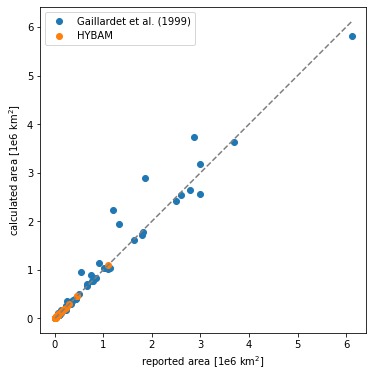

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

ref_line = np.array([np.min(basin_data['area']/1e6),
                     np.max(basin_data['area']/1e6)])

ax.plot(ref_line, ref_line, ls='--', c='C7')

ax.scatter(basin_data[basin_data['source']=='Gaillardet et al. (1999)']['area']/1e6,
           basin_mask_areas[basin_data['source']=='Gaillardet et al. (1999)']/1e6/1e6,
           c='C0', label='Gaillardet et al. (1999)')

ax.scatter(basin_data[basin_data['source']!='Gaillardet et al. (1999)']['area']/1e6,
           basin_mask_areas[basin_data['source']!='Gaillardet et al. (1999)']/1e6/1e6,
           c='C1', label='HYBAM')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('reported area [1e6 km$^{2}$]')
ax.set_ylabel('calculated area [1e6 km$^{2}$]')
ax.legend()

plt.show(fig)

Extract the lithology distribution over each of the watersheds:

In [12]:
basin_mask_lith_1 = np.zeros(len(basin_data))
basin_mask_lith_2 = np.zeros(len(basin_data))
basin_mask_lith_3 = np.zeros(len(basin_data))
basin_mask_lith_4 = np.zeros(len(basin_data))
basin_mask_lith_5 = np.zeros(len(basin_data))
basin_mask_lith_6 = np.zeros(len(basin_data))

lith_mask = Dataset('../output/lith_mask_360_720.nc')

for i in range(len(basin_data)):
    # pull out the basin mask
    if basin_data['basin'][i] in basin_mask_1.variables.keys():
        this_basin_mask = basin_mask_1.variables[basin_data['basin'][i]][:,:].data.copy()
    elif basin_data['basin'][i] in basin_mask_2.variables.keys():
        this_basin_mask = basin_mask_2.variables[basin_data['basin'][i]][:,:].data.copy()
    else:
        print('!! WARNING !! {} not in the basin masks!'.format(basin_data['basin'][j]))
        break
        
    this_basin_mask[np.isnan(this_basin_mask)] = 0
    this_basin_mask[this_basin_mask < 0] = 0
    
    basin_mask_lith_1[i] = np.nansum(lith_mask.variables['frac'][1,:,:].data * this_basin_mask)
    basin_mask_lith_2[i] = np.nansum(lith_mask.variables['frac'][2,:,:].data * this_basin_mask)
    basin_mask_lith_3[i] = np.nansum(lith_mask.variables['frac'][3,:,:].data * this_basin_mask)
    basin_mask_lith_4[i] = np.nansum(lith_mask.variables['frac'][4,:,:].data * this_basin_mask)
    basin_mask_lith_5[i] = np.nansum(lith_mask.variables['frac'][5,:,:].data * this_basin_mask)
    basin_mask_lith_6[i] = np.nansum(lith_mask.variables['frac'][6,:,:].data * this_basin_mask)
    
basin_data['mask_area'] = basin_mask_areas/1e6
basin_data['lith_1_frac'] = basin_mask_lith_1/basin_mask_areas
basin_data['lith_2_frac'] = basin_mask_lith_2/basin_mask_areas
basin_data['lith_3_frac'] = basin_mask_lith_3/basin_mask_areas
basin_data['lith_4_frac'] = basin_mask_lith_4/basin_mask_areas
basin_data['lith_5_frac'] = basin_mask_lith_5/basin_mask_areas
basin_data['lith_6_frac'] = basin_mask_lith_6/basin_mask_areas

## GEOCLIM Output

**NOTE: The raw GEOCLIM output is too large to be uploaded to GitHub, and therefore is not included within this repository. To access this raw data, please contact yuempark@berkeley.edu.**

**However, critical information has been extracted from the raw GEOCLIM output and saved in .csv's within the `output` folder in this repository - to simply read in this extracted data and bypass the raw GEOCLIM output, simply set `refresh_1` below to `False`, and `param_set` to `'combined'`.**

In [13]:
refresh_1 = False

# change this path to where the data is stored
path = '/Volumes/GEOCLIM/parameter-exploration/'

# choose 'combined' if you would like to concatenate all the parameter sets with varying krp
# but must have run refresh_1 on each parameter set individually beforehand
param_set = 'combined'

In [14]:
# perform the full watershed calculations
if refresh_1:
    
    # read in the file
    param_nc = Dataset(path+'parameter_exploration_'+param_set+'.nc')
    
    # get the parameters of interest out of the netCDF
    params = get_params(param_nc)
    params.to_csv('../output/params_'+param_set+'.csv', index=False)
    
    # get the silicate weathering for each basin for each run, in t/km2/yr of Ca+Mg+Na+K:
    basin_model, total_CO2_consumption = extract_basin_variables(param_nc)
    basin_model.to_csv('../output/basin_model_'+param_set+'.csv', index=False)
    np.savetxt('../output/total_CO2_consumption_'+param_set+'.csv', total_CO2_consumption, delimiter=',')

# concatenate the 30min parameter sets with varying krp
elif param_set == 'combined':
    
    # set refresh_1 to be False
    refresh_1 = False
    
    # concatenate
    param_set_list = ['krp_1_2_e-3','krp_2_0_e-3','krp_3_0_e-3','krp_5_0_e-3','krp_1_0_e-2','krp_1_5_e-2']
    
    params = pd.read_csv('../output/params_'+param_set_list[0]+'.csv')
    basin_model = pd.read_csv('../output/basin_model_'+param_set_list[0]+'.csv')
    total_CO2_consumption = np.loadtxt('../output/total_CO2_consumption_'+param_set_list[0]+'.csv', delimiter=',')
    
    for i in range(1,len(param_set_list)):
        params_subset = pd.read_csv('../output/params_'+param_set_list[i]+'.csv')
        basin_model_subset = pd.read_csv('../output/basin_model_'+param_set_list[i]+'.csv')
        total_CO2_consumption_subset = np.loadtxt('../output/total_CO2_consumption_'+param_set_list[i]+'.csv',
                                                  delimiter=',')
        
        params = pd.concat([params,params_subset], ignore_index=True)
        basin_model = pd.concat([basin_model,basin_model_subset], ignore_index=True)
        total_CO2_consumption = np.append(total_CO2_consumption, total_CO2_consumption_subset)
    
# just read in a single parameter set
else:
    
    # read in the previous calculations
    params = pd.read_csv('../output/params_'+param_set+'.csv')
    basin_model = pd.read_csv('../output/basin_model_'+param_set+'.csv')
    total_CO2_consumption = np.loadtxt('../output/total_CO2_consumption_'+param_set+'.csv', delimiter=',')
    
run_ID = np.arange(len(total_CO2_consumption))

In [15]:
print('number of runs: {}'.format(len(params)))

number of runs: 93600


In [16]:
basin_model.head()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
0,0.000232,0.000042,0.000005,0.000360,0.000087,0.000008,0.000001,0.000029,3.886691e-07,0.000100,0.000002,0.000050,0.000170,0.000057,0.000022,0.000003,0.000290,0.000530,0.000060,0.000009,0.000003,0.000003,0.000003,0.000001,0.000014,0.000009,0.000170,0.000036,0.000150,0.000175,0.000001,0.000347,0.000014,0.000386,0.000002,0.000785,0.000050,1.715869e-07,0.000675,0.000002,0.000040,0.000254,0.000004,0.000225,0.000007,0.000002,0.000005,0.001491,0.000018,0.000006,0.000256,0.000089,0.000227,0.000073,0.000716,0.000093,0.000148,0.000145,0.000627,0.000129,0.000220,0.000178,0.000109,0.000156,0.000058,0.000531,0.000295,0.000189,0.000052,0.000031,0.000097,0.000027,0.000031,0.000096,0.000743,0.000348,0.000014,0.000020,0.000017,0.000131,0.000227
1,0.000333,0.000061,0.000010,0.000498,0.000123,0.000009,0.000002,0.000031,4.743136e-07,0.000136,0.000003,0.000056,0.000226,0.000079,0.000035,0.000003,0.000352,0.000585,0.000063,0.000013,0.000003,0.000006,0.000003,0.000002,0.000021,0.000011,0.000213,0.000050,0.000244,0.000212,0.000002,0.000458,0.000015,0.000400,0.000003,0.000831,0.000053,2.437201e-07,0.000679,0.000004,0.000043,0.000260,0.000007,0.000226,0.000009,0.000002,0.000008,0.001534,0.000019,0.000012,0.000296,0.000140,0.000453,0.000116,0.000741,0.000186,0.000224,0.000177,0.000966,0.000178,0.000284,0.000340,0.000203,0.000293,0.000115,0.000655,0.000590,0.000379,0.000103,0.000059,0.000128,0.000052,0.000063,0.000109,0.000951,0.000432,0.000016,0.000021,0.000020,0.000149,0.000245
2,0.000246,0.000043,0.000005,0.000379,0.000098,0.000008,0.000001,0.000032,3.994651e-07,0.000100,0.000002,0.000051,0.000172,0.000069,0.000024,0.000003,0.000303,0.000553,0.000060,0.000010,0.000003,0.000003,0.000003,0.000001,0.000014,0.000009,0.000174,0.000038,0.000150,0.000201,0.000001,0.000358,0.000016,0.000388,0.000002,0.000785,0.000051,1.728953e-07,0.000692,0.000002,0.000049,0.000255,0.000004,0.000275,0.000009,0.000002,0.000005,0.001491,0.000019,0.000007,0.000286,0.000090,0.000227,0.000075,0.000789,0.000093,0.000161,0.000153,0.000636,0.000147,0.000223,0.000179,0.000112,0.000158,0.000058,0.000546,0.000295,0.000189,0.000052,0.000031,0.000101,0.000027,0.000031,0.000107,0.000747,0.000382,0.000014,0.000020,0.000017,0.000136,0.000227
3,0.000346,0.000062,0.000010,0.000517,0.000134,0.000009,0.000002,0.000035,4.851096e-07,0.000137,0.000003,0.000057,0.000228,0.000090,0.000036,0.000003,0.000365,0.000608,0.000063,0.000013,0.000003,0.000006,0.000003,0.000002,0.000022,0.000011,0.000217,0.000052,0.000244,0.000238,0.000002,0.000470,0.000017,0.000402,0.000003,0.000831,0.000053,2.450285e-07,0.000695,0.000004,0.000052,0.000261,0.000007,0.000276,0.000010,0.000002,0.000008,0.001534,0.000020,0.000012,0.000326,0.000141,0.000453,0.000118,0.000814,0.000186,0.000236,0.000184,0.000975,0.000195,0.000286,0.000341,0.000206,0.000295,0.000115,0.000671,0.000590,0.000379,0.000103,0.000060,0.000131,0.000053,0.000063,0.000120,0.000956,0.000465,0.000016,0.000021,0.000020,0.000153,0.000245
4,0.000446,0.000082,0.000014,0.000655,0.000170,0.000009,0.000003,0.000037,5.707541e-07,0.000173,0.000005,0.000063,0.000285,0.000112,0.000048,0.000004,0.000427,0.000664,0.000066,0.000017,0.000003,0.000009,0.000004,0.000003,0.000029,0.000013,0.000260,0.000067,0.000337,0.000276,0.000003,0.000581,0.000017,0.000416,0.000003,0.000878,0.000055,3.171616e-07,0.000698,0.000006,0.000055,0.000267,0.000009,0.000277,0.000012,0.000002,0.000011,0.001576,0.000022,0.000018,0.000366,0.000192,0.000680,0.000161,0.000839,0.000278,0.000312,0.00021

In [17]:
basin_model.tail()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
93595,10.820835,20.782372,1.886899,50.725789,36.800412,35.046501,6.398030,12.194926,13.870388,12.168611,4.395882,4.168720,19.126128,6.219363,9.753491,16.963744,12.170116,62.178565,32.255651,33.459566,1.436988,1.060599,6.626425,4.007535,27.064902,6.713498,38.319779,87.998169,7.520907,8.493865,0.404236,27.576688,5.507645,16.086314,1.012304,52.123265,59.231280,16.560076,18.730007,1.767473,4.176060,13.050228,7.982802,17.145301,2.908693,40.443313,1.102884,62.961974,3.977536,12.167032,7.151474,41.182003,2.500999,39.201436,25.650339,1.896397,57.515736,79.135199,39.418890,4.637416,4.394132,10.660291,1.639085,3.819316,9.162701,94.972496,3.066006,1.955746,2.855824,3.190522,68.900967,15.059389,18.162991,58.092752,90.065327,5.028489,68.612814,59.436712,53.381076,42.227764,45.733795
93596,12.679343,25.952045,2.389288,58.301564,39.945429,36.046788,8.369182,12.538412,15.220410,15.292459,5.263542,4.606392,23.104926,6.853507,11.916968,19.447418,14.229473,66.103097,34.568498,36.097090,1.865656,1.590898,7.262336,5.184174,31.330879,7.412872,46.085484,91.816664,10.264298,9.301827,0.569931,32.346430,5.567724,16.536968,1.212402,54.736848,62.621726,19.459677,18.833381,2.557499,4.291758,13.236877,10.409795,17.181848,3.097609,41.065840,1.511219,64.272788,4.154735,17.215674,7.757428,48.167667,3.744250,45.592194,26.303809,2.844595,64.813681,80.802832,48.007379,5.378984,5.351670,13.875688,2.321999,4.589510,13.019675,103.573780,4.599009,2.933620,4.283736,4.652014,71.097717,22.375526,26.994100,61.522126,103.719826,5.623305,71.152382,61.486344,60.792432,46.260042,47.332349
93597,14.537850,31.121720,2.891677,65.877330,43.090450,37.047075,10.340332,12.881898,16.570438,18.416307,6.131201,5.044064,27.083728,7.487650,14.080445,21.931090,16.288832,70.027615,36.881348,38.734612,2.294324,2.121198,7.898248,6.360812,35.596858,8.112247,53.851189,95.635148,13.007690,10.109791,0.735626,37.116171,5.627801,16.987623,1.412499,57.350431,66.012181,22.359276,18.936752,3.347525,4.407456,13.423523,12.836787,17.218399,3.286526,41.688371,1.919554,65.583608,4.331934,22.264314,8.363382,55.153332,4.987501,51.982946,26.957281,3.792793,72.111630,82.470455,56.595860,6.120551,6.309208,17.091085,3.004914,5.359704,16.876647,112.175064,6.132013,3.911493,5.711647,6.113505,73.294468,29.691660,35.825210,64.951506,117.374344,6.218123,73.691950,63.535986,68.203788,50.292315,48.930902
93598,16.396357,36.291395,3.394066,73.453095,46.235463,38.047365,12.311484,13.225386,17.920461,21.540155,6.998861,5.481736,31.062529,8.121793,16.243921,24.414764,18.348188,73.952147,39.194199,41.372139,2.722992,2.651498,8.534160,7.537451,39.862833,8.811621,61.616894,99.453643,15.751083,10.917754,0.901321,41.885912,5.687880,17.438278,1.612596,59.964024,69.402628,25.258878,19.040125,4.137550,4.523154,13.610174,15.263781,17.254947,3.475443,42.310902,2.327890,66.894428,4.509133,27.312956,8.969335,62.139006,6.230752,58.373709,27.610753,4.740992,79.409580,84.138079,65.184350,6.862118,7.266746,20.306485,3.687829,6.129898,20.733624,120.776358,7.665015,4.889366,7.139559,7.574996,75.491209,37.007799,44.656320,68.380876,131.028872,6.812940,76.231508,65.585623,75.615153,54.324603,50.529461
93599,18.254865,41.461071,3.896455,81.028861,49.380484,39.047648,14.282634,13.568870,19.270487,24.664005,7.866521,5.919408,35.041329,8.755938,18.407398,26.898438,20.407545,77.876662,41.507050,44.009660,3.151660,3.181797,9.170070,8.714089,44.128810,9.510996,69.382594,103.272128,18.494475,11.725717,1.067016,46.655654,5.747957,17.888931,1.81

Are there any basins where the weathering rate is 0?

In [18]:
basin_model.columns[np.unique(np.where(basin_model.values==0)[1])]

Index([], dtype='object')

## Model-Data Comparison

Do the regression:

In [19]:
r2s = get_regression_coefficient(basin_data['CaMgNaK_sil_norm'], basin_model.values)

Plot against total CO$_{2}$ consumption:

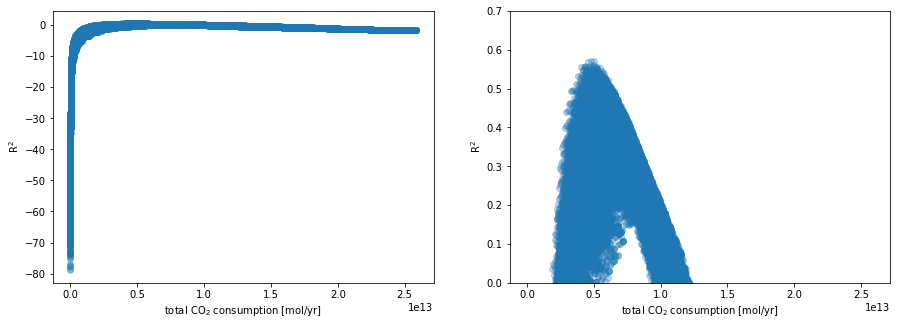

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].set_ylim(0,0.7)

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

Plot against WSI (weathering saturation index):

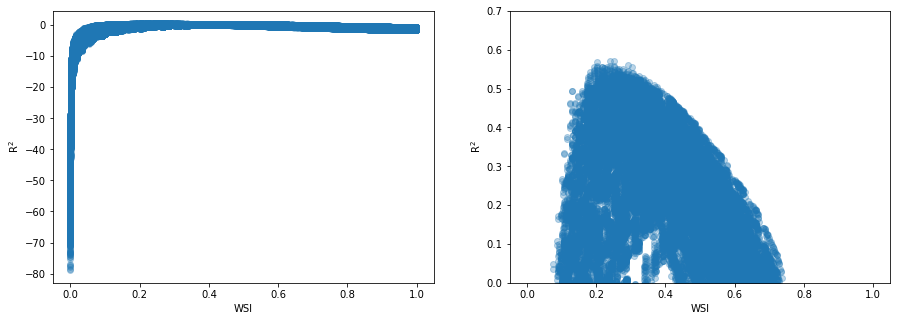

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(params['WSI'], r2s, alpha=0.3)
ax[1].scatter(params['WSI'], r2s, alpha=0.3)
ax[1].set_ylim(0,.7)

ax[0].set_xlabel('WSI')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('WSI')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

The best perfoming run:

In [22]:
best_ind = np.argwhere(r2s == np.max(r2s))

best_Kwest = params['Kwest'][best_ind[0][0]]
best_kw = params['kw'][best_ind[0][0]]
best_sigma = params['sigma'][best_ind[0][0]]
best_CaMg_1 = params['CaMg_1'][best_ind[0][0]]
best_CaMg_6 = params['CaMg_6'][best_ind[0][0]]
best_krp = params['krp'][best_ind[0][0]]
best_total_CO2_consumption = total_CO2_consumption[best_ind[0][0]]
best_WSI = params['WSI'][best_ind[0][0]]

print('R^2                   = {:.3f}'.format(np.max(r2s)))
print('Kwest                 = {}'.format(best_Kwest))
print('kw                    = {}'.format(best_kw))
print('sigma                 = {}'.format(best_sigma))
print('CaMg_1                = {}'.format(best_CaMg_1))
print('CaMg_6                = {}'.format(best_CaMg_6))
print('krp                   = {}'.format(best_krp))
print('total_CO2_consumption = {}'.format(best_total_CO2_consumption))
print('WSI                   = {}'.format(best_WSI))

R^2                   = 0.570
Kwest                 = 0.0005
kw                    = 1.0
sigma                 = -0.4
CaMg_1                = 2500.0
CaMg_6                = 2000.0
krp                   = 0.009999999776482582
total_CO2_consumption = 4798810161152.0
WSI                   = 0.24076238


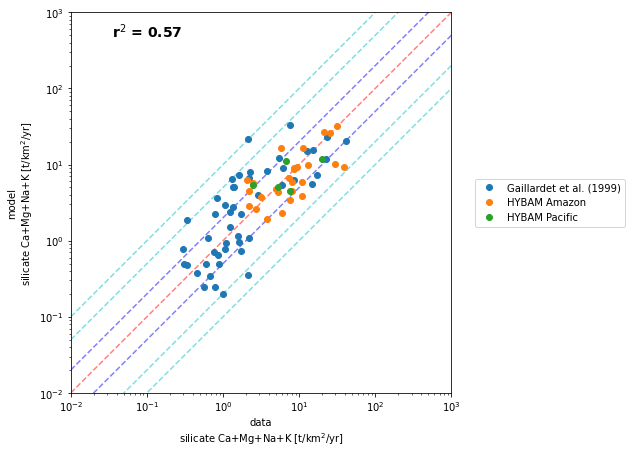

In [23]:
fig, ax = plt.subplots(figsize=(7,7))

log_cross_plot(basin_model.loc[best_ind[0][0]],
               basin_data['CaMgNaK_sil_norm'],
               basin_data['source'],
               np.max(r2s),
               ax,
               legend=True, labels=True)
    
plt.show(fig)

Plot maps for this best perfoming run - Fig. S5.

**NOTE: The raw GEOCLIM output is too large to be uploaded to GitHub, and therefore is not included within this repository. To access this raw data, please contact yuempark@berkeley.edu.**

In [24]:
selected_nc = Dataset(path + 'parameter_exploration_krp_1_0_e-2.nc')

In [25]:
selected_nc_ind = np.where((selected_nc.variables['Kwest'][:].data==best_Kwest)&
                           (selected_nc.variables['kw'][:].data==best_kw)&
                           (selected_nc.variables['sigma'][:].data==best_sigma)&
                           (selected_nc.variables['CaMg'][:,0].data==best_CaMg_1)&
                           (selected_nc.variables['CaMg'][:,5].data==best_CaMg_6))[0][0]

In [26]:
best_weathering_map = selected_nc.variables['weathering'][selected_nc_ind,:,:].data
best_weathering_map[best_weathering_map>1e30] = np.nan

best_thickness_map = selected_nc.variables['reg_thickness'][:,:].data
best_thickness_map[best_thickness_map>1e30] = np.nan

/Users/yuempark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


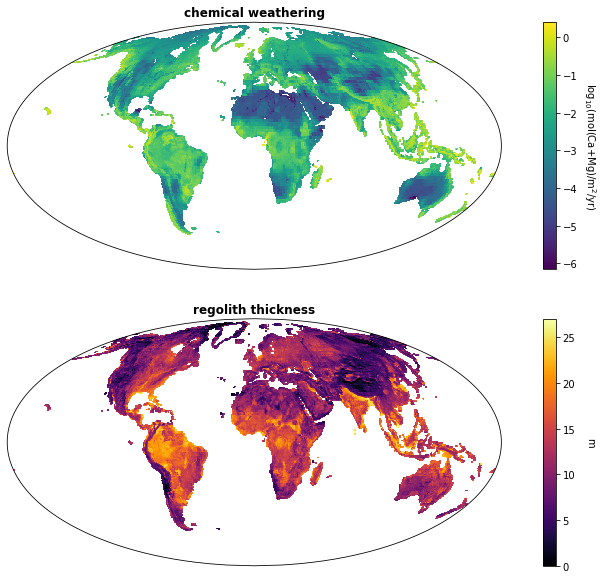

In [27]:
fig = plt.figure(figsize=(15,10))

# weathering map
ax = plt.subplot(2,1,1, projection=ccrs.Mollweide())

im = ax.pcolormesh(selected_nc.variables['lon'][:].data,
                   selected_nc.variables['lat'][:].data,
                   np.log10(best_weathering_map),
                   transform=ccrs.PlateCarree(), cmap='viridis')

ax.set_title('chemical weathering', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log$_{10}$(mol(Ca+Mg)/m$^{2}$/yr)', rotation=270, labelpad=20)

# regolith thickness map
ax = plt.subplot(2,1,2, projection=ccrs.Mollweide())

im = ax.pcolormesh(selected_nc.variables['lon'][:].data,
                   selected_nc.variables['lat'][:].data,
                   best_thickness_map,
                   transform=ccrs.PlateCarree(), cmap='inferno')

ax.set_title('regolith thickness', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

plt.savefig('../../figures/weathering_regolith_maps.jpg', bbox_inches='tight', dpi=300)
plt.show(fig)

/Users/yuempark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


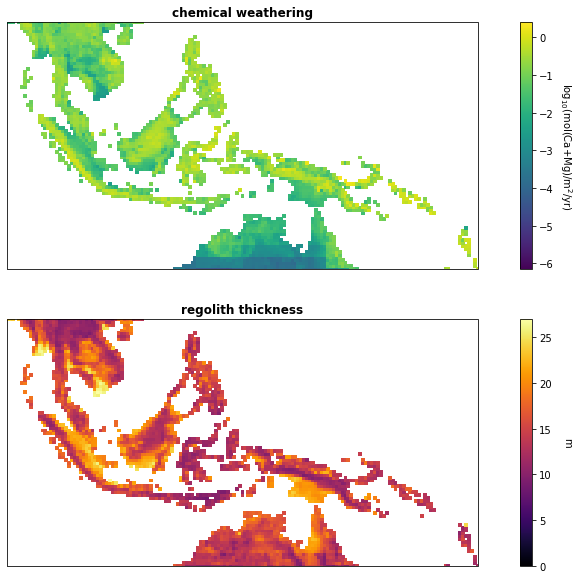

In [28]:
fig = plt.figure(figsize=(15,10))

IA_xlim = (90,170)
IA_ylim = (-20,22)

# weathering map
ax = plt.subplot(2,1,1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(selected_nc.variables['lon'][:].data,
                   selected_nc.variables['lat'][:].data,
                   np.log10(best_weathering_map),
                   transform=ccrs.PlateCarree(), cmap='viridis')
ax.set_ylim(IA_ylim)
ax.set_xlim(IA_xlim)

ax.set_title('chemical weathering', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log$_{10}$(mol(Ca+Mg)/m$^{2}$/yr)', rotation=270, labelpad=20)

# regolith thickness map
ax = plt.subplot(2,1,2, projection=ccrs.PlateCarree())

im = ax.pcolormesh(selected_nc.variables['lon'][:].data,
                   selected_nc.variables['lat'][:].data,
                   best_thickness_map,
                   transform=ccrs.PlateCarree(), cmap='inferno')
ax.set_ylim(IA_ylim)
ax.set_xlim(IA_xlim)

ax.set_title('regolith thickness', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

plt.show(fig)

Remove runs that have low R$^{2}$:

In [29]:
r2_95_percentile = np.percentile(r2s, 95)
print('95th percentile of r^2 = {:.2f}'.format(r2_95_percentile))

95th percentile of r^2 = 0.41


In [30]:
r2_99_percentile = np.percentile(r2s, 99)
print('99th percentile of r^2 = {:.2f}'.format(r2_99_percentile))

99th percentile of r^2 = 0.49


In [31]:
drop_inds = np.argwhere(r2s<=0.5).flatten()

best_basin_model = basin_model.copy()
best_basin_model.drop(drop_inds, inplace=True)
best_basin_model.reset_index(inplace=True, drop=True)

best_params = params.copy()
best_params.drop(drop_inds, inplace=True)
best_params.reset_index(inplace=True, drop=True)

best_total_CO2_consumption = np.delete(total_CO2_consumption, drop_inds)

best_r2s = np.delete(r2s, drop_inds)

best_run_ID = np.delete(run_ID, drop_inds)

In [32]:
print('number of remaining runs = {}'.format(len(best_r2s)))

number of remaining runs = 573


Gerlach (2011) estimates global CO$_{2}$ consumption:

* all estimates = 0.285 ± 0.155 Gt/y (0.13-0.44)
* preferred estimates = 0.205 ± 0.055 Gt/y (0.15-0.26)

> Gerlach, T. (2011), Volcanic versus anthropogenic carbon dioxide, Eos Trans. AGU, 92(24), 201–202, doi:10.1029/2011EO240001

Lee et al. (2019) estimates endogenic C fluxes:

* 0.071-0.393 Gt/y

> Lee, C.-T. A., Jiang, H., Dasgupta, R., and Torres, M., 2019, A framework for understanding whole-Earth carbon cycling: Deep Carbon, pp. 313–357, doi:10.1017/9781108677950.011.

In [33]:
# Gt/y of CO2
Gerlach_all = np.array([0.13, 0.44])
Gerlach_preferred = np.array([0.15, 0.26])

# convert to mol/yr
FW = 44.01
Gerlach_all = (Gerlach_all * 1e9 * 1e6) / FW
Gerlach_preferred = (Gerlach_preferred * 1e9 * 1e6) / FW

print(Gerlach_all)
print(Gerlach_preferred)

[2.95387412e+12 9.99772779e+12]
[3.40831629e+12 5.90774824e+12]


In [34]:
# Gt/y of C
Lee_all = np.array([0.071, 0.393])

# convert to mol/yr
FW = 12.01
Lee_all = (Lee_all * 1e9 * 1e6) / FW

print(Lee_all)

[5.91174022e+12 3.27227311e+13]


CO$_{2}$ consumption vs. R$^{2}$ - Fig. S3.

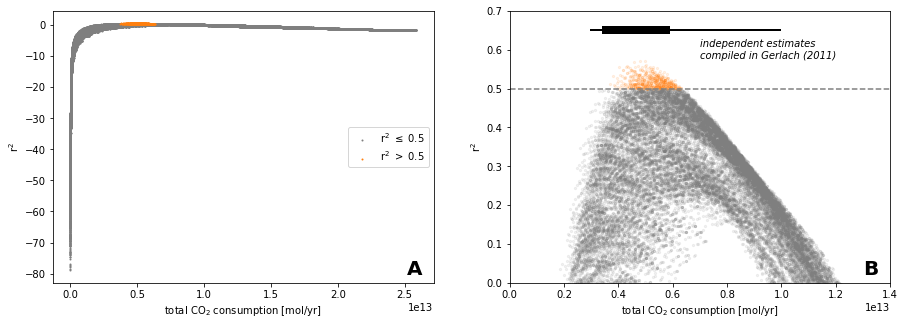

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption[drop_inds], r2s[drop_inds], c='C7', label='r$^{2}$ $\leq$ 0.5', s=1)
ax[0].scatter(best_total_CO2_consumption, best_r2s, c='C1', label='r$^{2}$ $>$ 0.5', s=1)

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('r$^{2}$')
ax[0].legend(loc='center right')

ax[1].scatter(total_CO2_consumption[drop_inds], r2s[drop_inds], alpha=0.1, c='C7', s=5)
ax[1].scatter(best_total_CO2_consumption, best_r2s, alpha=0.1, c='C1', s=5)
ax[1].set_ylim(0,0.7)
ax[1].set_xlim(0,1.4e13)

ax[1].axhline(0.5, ls='--', c='C7')

ax[1].hlines(y=0.65, xmin=Gerlach_all[0], xmax=Gerlach_all[1], color='k', lw=2)
ax[1].hlines(y=0.65, xmin=Gerlach_preferred[0], xmax=Gerlach_preferred[1], color='k', lw=8)
ax[1].text(0.7e13, 0.6, 'independent estimates\ncompiled in Gerlach (2011)', style='italic', fontsize=10,
           horizontalalignment='left', verticalalignment='center')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('r$^{2}$')

ax[0].text(0.95, 0.05, 'A', fontweight='bold', fontsize=20,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.95, 0.05, 'B', fontweight='bold', fontsize=20,
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

plt.savefig('../../figures/W_vs_r2.jpg', bbox_inches='tight', dpi=300)
plt.show(fig)

In [36]:
print('CO2 consumption of good fits :')
print('max  = {:.1f} e12'.format(np.max(best_total_CO2_consumption/1e12)))
print('min  = {:.1f} e12'.format(np.min(best_total_CO2_consumption/1e12)))
print('mean = {:.1f} e12'.format(np.mean(best_total_CO2_consumption/1e12)))
print('std  = {:.1f} e12'.format(np.std(best_total_CO2_consumption/1e12)))

CO2 consumption of good fits :
max  = 6.3 e12
min  = 3.7 e12
mean = 5.2 e12
std  = 0.5 e12


Cross plot the results.

SEAI basins:

* Fly
* Kikori
* Purari
* Sepik

In [37]:
SEAI_basins = ['fly','kikori','purari','sepik']

# separate SEAI and non-SEAI basins
basin_data_SEAI = basin_data[basin_data['basin'].isin(SEAI_basins)]
basin_data_nonSEAI = basin_data[~basin_data['basin'].isin(SEAI_basins)]

# get names of non-SEAI G1999 and HYBAM basins
G1999_basins = basin_data_nonSEAI[basin_data_nonSEAI['source']=='Gaillardet et al. (1999)']['basin']
HYBAM_basins = basin_data_nonSEAI[basin_data_nonSEAI['source']!='Gaillardet et al. (1999)']['basin']

# separate non-SEAI G1999 and HYBAM basins
basin_data_G1999 = basin_data_nonSEAI[basin_data_nonSEAI['basin'].isin(G1999_basins)]
basin_data_HYBAM = basin_data_nonSEAI[basin_data_nonSEAI['basin'].isin(HYBAM_basins)]

# select the test runs, then separate the 3 categories
basin_model_slice = basin_model.loc[best_run_ID]
basin_model_SEAI = basin_model_slice[SEAI_basins]
basin_model_G1999 = basin_model_slice[G1999_basins]
basin_model_HYBAM = basin_model_slice[HYBAM_basins]

# calculate mean, max, min
run_mean_SEAI = np.mean(basin_model_SEAI, axis=0)
run_max_SEAI = np.max(basin_model_SEAI, axis=0)
run_min_SEAI = np.min(basin_model_SEAI, axis=0)

run_mean_G1999 = np.mean(basin_model_G1999, axis=0)
run_max_G1999 = np.max(basin_model_G1999, axis=0)
run_min_G1999 = np.min(basin_model_G1999, axis=0)

run_mean_HYBAM = np.mean(basin_model_HYBAM, axis=0)
run_max_HYBAM = np.max(basin_model_HYBAM, axis=0)
run_min_HYBAM = np.min(basin_model_HYBAM, axis=0)

Fig. S4:

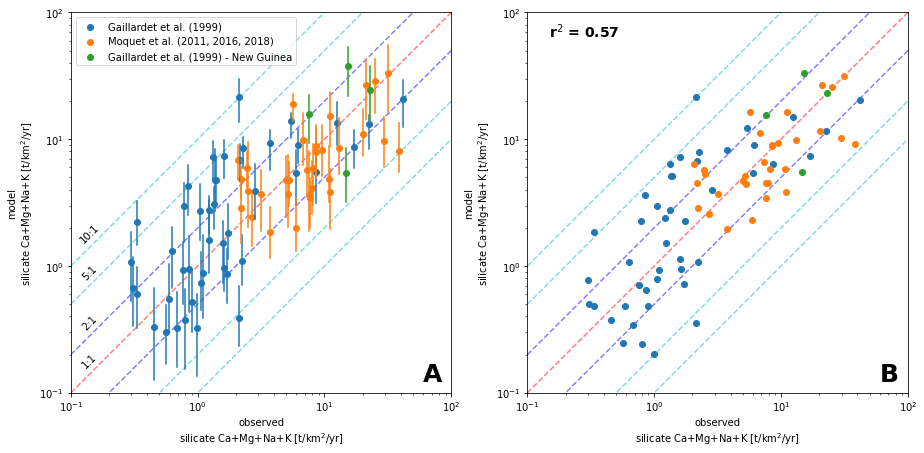

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

# Ca + Mg + Na + K
xlim = np.array([1e-1, 1e2])
ylim = np.array([1e-1, 1e2])

# reference lines
for i in range(2):
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)

    ax[i].plot(xlim, ylim, c='r', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*2, c='b', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*(1/2), c='b', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*5, c='c', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*(1/5), c='c', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*10, c='c', ls='--', zorder=-99, alpha=0.5)
    ax[i].plot(xlim, ylim*(1/10), c='c', ls='--', zorder=-99, alpha=0.5)
    
# plot min-max error bars
ax[0].plot([basin_data_G1999['CaMgNaK_sil_norm'], basin_data_G1999['CaMgNaK_sil_norm']],
           [run_min_G1999, run_max_G1999],
           c='C0')
ax[0].plot([basin_data_HYBAM['CaMgNaK_sil_norm'], basin_data_HYBAM['CaMgNaK_sil_norm']],
           [run_min_HYBAM, run_max_HYBAM],
           c='C1')
ax[0].plot([basin_data_SEAI['CaMgNaK_sil_norm'], basin_data_SEAI['CaMgNaK_sil_norm']],
           [run_min_SEAI, run_max_SEAI],
           c='C2')

# plot mean
ax[0].scatter(basin_data_G1999['CaMgNaK_sil_norm'], run_mean_G1999,
              c='C0', label='Gaillardet et al. (1999)')
ax[0].scatter(basin_data_HYBAM['CaMgNaK_sil_norm'], run_mean_HYBAM,
              c='C1', label='Moquet et al. (2011, 2016, 2018)')
ax[0].scatter(basin_data_SEAI['CaMgNaK_sil_norm'], run_mean_SEAI,
              c='C2', label='Gaillardet et al. (1999) - New Guinea')

# plot best perfoming run
ax[1].scatter(basin_data_G1999['CaMgNaK_sil_norm'], basin_model_G1999.loc[best_ind[0][0]])
ax[1].scatter(basin_data_HYBAM['CaMgNaK_sil_norm'], basin_model_HYBAM.loc[best_ind[0][0]])
ax[1].scatter(basin_data_SEAI['CaMgNaK_sil_norm'], basin_model_SEAI.loc[best_ind[0][0]])
        
ax[1].text(0.15, 0.95, 'r$^2$ = {:.2f}'.format(np.max(best_r2s)), fontsize=14, fontweight='bold',
           horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes)
    
for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_aspect('equal', adjustable='box')

    ax[i].set_xlabel('observed\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
    ax[i].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

ax[0].legend(loc='upper left')

ax[0].text(0.95, 0.05, 'A', fontweight='bold', fontsize=25,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.95, 0.05, 'B', fontweight='bold', fontsize=25,
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

ax[0].text(0.05, 0.420, '10:1', rotation=45,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.05, 0.315, '5:1', rotation=45,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.05, 0.185, '2:1', rotation=45,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.05, 0.085, '1:1', rotation=45,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

plt.savefig('../../figures/r2_cross_plot.pdf', bbox_inches='tight')
plt.show(fig)

Make histograms:

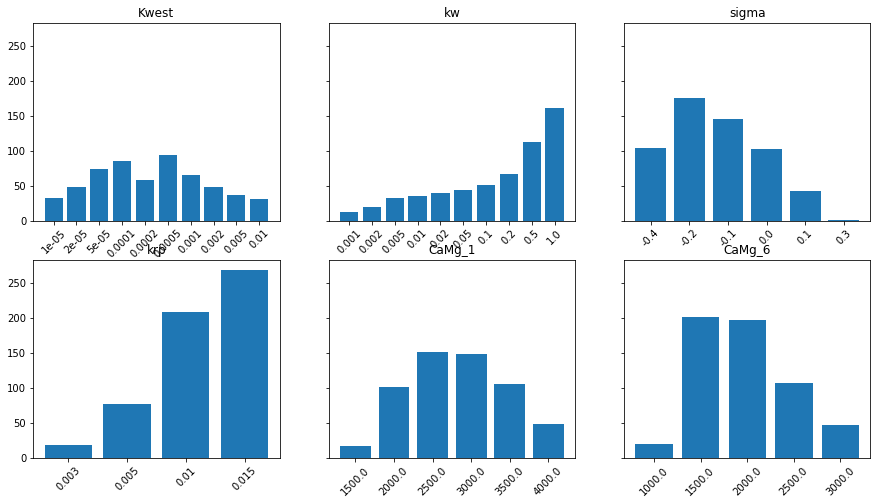

In [39]:
changing_params = ['Kwest','kw','sigma','krp','CaMg_1','CaMg_6']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8), sharey=True)

ax = ax.flatten()

for i in range(len(changing_params)):
    unique_vals = np.array(best_params[changing_params[i]].unique())
    unique_vals = np.sort(unique_vals)
    
    x_index = np.arange(len(unique_vals))
    y_vals = np.zeros(len(unique_vals))
    
    for j in range(len(unique_vals)):
        y_vals[j] = len(best_params[best_params[changing_params[i]]==unique_vals[j]])
    
    ax[i].bar(x_index,y_vals)
    
    ax[i].set_xticks(x_index)
    ax[i].set_xticklabels(np.round(unique_vals,7), rotation=45)
    
    ax[i].set_title(changing_params[i])

plt.show(fig)

## Mean Ca+Mg

In [40]:
cell_area = Dataset('../output/cell_area_360_720.nc')
land_area = Dataset('../output/land_area_360_720.nc')

For all parameter combinations:

In [41]:
mean_CaMg = np.zeros(len(best_params))

# resulting units here are m^2
cell_area_1 = lith_mask.variables['frac'][1,:,:].data * cell_area.variables['area'][:,:]
cell_area_2 = lith_mask.variables['frac'][2,:,:].data * cell_area.variables['area'][:,:]
cell_area_3 = lith_mask.variables['frac'][3,:,:].data * cell_area.variables['area'][:,:]
cell_area_4 = lith_mask.variables['frac'][4,:,:].data * cell_area.variables['area'][:,:]
cell_area_6 = lith_mask.variables['frac'][6,:,:].data * cell_area.variables['area'][:,:]

for i in range(len(best_params)):
    
    # resulting units here are mol/m
    sum_CaMg_1 = np.nansum(cell_area_1 * best_params['CaMg_1'][i])
    sum_CaMg_2 = np.nansum(cell_area_2 * best_params['CaMg_2'][i])
    sum_CaMg_3 = np.nansum(cell_area_3 * best_params['CaMg_3'][i])
    sum_CaMg_4 = np.nansum(cell_area_4 * best_params['CaMg_4'][i])
    sum_CaMg_6 = np.nansum(cell_area_6 * best_params['CaMg_6'][i])
    
    # resulting units here are mol/m
    sum_CaMg = sum_CaMg_1 + sum_CaMg_2 + sum_CaMg_3 + sum_CaMg_4 + sum_CaMg_6

    # resulting units here are mol/m^3
    mean_CaMg[i] = sum_CaMg / np.nansum(land_area.variables['area'][:,:])

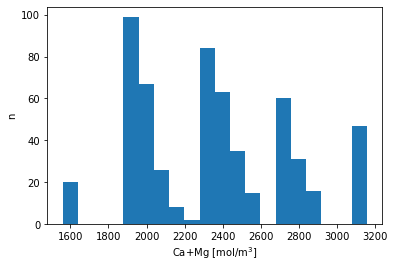

In [42]:
fig, ax = plt.subplots()

ax.hist(mean_CaMg, bins=20)
ax.set_xlabel('Ca+Mg [mol/m$^{3}$]')
ax.set_ylabel('n')

plt.show(fig)

For the best parameter combination:

In [43]:
sum_CaMg_1 = np.nansum(cell_area_1 * 2500)
sum_CaMg_2 = np.nansum(cell_area_2 * best_params['CaMg_2'][0])
sum_CaMg_3 = np.nansum(cell_area_3 * best_params['CaMg_3'][0])
sum_CaMg_4 = np.nansum(cell_area_4 * best_params['CaMg_4'][0])
sum_CaMg_6 = np.nansum(cell_area_6 * 2000)

# resulting units here are mol/m
sum_CaMg = sum_CaMg_1 + sum_CaMg_2 + sum_CaMg_3 + sum_CaMg_4 + sum_CaMg_6

# resulting units here are mol/m^3
best_mean_CaMg = sum_CaMg / np.nansum(land_area.variables['area'][:,:])
print(best_mean_CaMg)

2320.7493


For the best parameter combination, replacing the Deccan with ocean:

In [44]:
Deccan_mask_nc = Dataset('/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/Land_Masks/Deccan_mask.nc')
Deccan_mask = Deccan_mask_nc.variables['Band1'][:,:].data
Deccan_mask[np.isnan(Deccan_mask)] = 0
Deccan_mask[Deccan_mask > 1e30] = 0

# replace the Deccan with ocean
lith_mask_noDeccan = lith_mask.variables['frac'][:,:,:].data.copy()
lith_mask_noDeccan[4,:,:][Deccan_mask==1] = 0

land_area_noDeccan = land_area.variables['area'][:,:].data.copy()
land_area_noDeccan[Deccan_mask==1] = land_area.variables['area'][:,:].data[Deccan_mask==1] *\
                                     (1-lith_mask.variables['frac'][4,:,:].data[Deccan_mask==1])

# resulting units here are m^2
cell_area_1_noDeccan = lith_mask_noDeccan[1,:,:] * cell_area.variables['area'][:,:]
cell_area_2_noDeccan = lith_mask_noDeccan[2,:,:] * cell_area.variables['area'][:,:]
cell_area_3_noDeccan = lith_mask_noDeccan[3,:,:] * cell_area.variables['area'][:,:]
cell_area_4_noDeccan = lith_mask_noDeccan[4,:,:] * cell_area.variables['area'][:,:]
cell_area_6_noDeccan = lith_mask_noDeccan[6,:,:] * cell_area.variables['area'][:,:]

# resulting units here are mol/m
sum_CaMg_1 = np.nansum(cell_area_1_noDeccan * 2500)
sum_CaMg_2 = np.nansum(cell_area_2_noDeccan * best_params['CaMg_2'][0])
sum_CaMg_3 = np.nansum(cell_area_3_noDeccan * best_params['CaMg_3'][0])
sum_CaMg_4 = np.nansum(cell_area_4_noDeccan * best_params['CaMg_4'][0])
sum_CaMg_6 = np.nansum(cell_area_6_noDeccan * 2000)

# resulting units here are mol/m
sum_CaMg = sum_CaMg_1 + sum_CaMg_2 + sum_CaMg_3 + sum_CaMg_4 + sum_CaMg_6

# resulting units here are mol/m^3
best_mean_CaMg_noDeccan = sum_CaMg / np.nansum(land_area_noDeccan)
print(best_mean_CaMg_noDeccan)

2290.735


## Parameter Sets For Testing

In [45]:
drop_inds = np.argwhere(r2s<=0.5).flatten()

best_basin_model = basin_model.copy()
best_basin_model.drop(drop_inds, inplace=True)
best_basin_model.reset_index(inplace=True, drop=True)

best_params = params.copy()
best_params.drop(drop_inds, inplace=True)
best_params.reset_index(inplace=True, drop=True)

best_total_CO2_consumption = np.delete(total_CO2_consumption, drop_inds)

best_r2s = np.delete(r2s, drop_inds)

best_run_ID = np.delete(run_ID, drop_inds)

If desired, order the runs based on greatest parameterization difference:

In [46]:
# choose False for both if you don't want to sort
refresh_2 = True
read_in_sorted_pcc = False

if refresh_2:

    test_run_ID = np.zeros_like(best_run_ID)
    test_max_pcc = np.zeros(len(best_run_ID))
    test_ind = np.zeros_like(best_run_ID)

    # get the best performing run
    best_ind = np.argwhere(best_r2s == np.max(best_r2s))

    test_run_ID[0] = best_run_ID[best_ind[0][0]]
    test_max_pcc[0] = 0
    test_ind[0] = best_ind[0][0]

    # get the run that has the smallest maximum Pearson correlation coefficient with all preceding selected test runs
    pcc_matrix = np.corrcoef(basin_model.loc[best_run_ID])

    for i in tqdm(range(1,len(best_run_ID))):
        # get the indices of runs we have already selected
        current_test_ind = test_ind[:i]

        # get the pcc matrix for those runs
        current_pcc_matrix = pcc_matrix[current_test_ind, :]

        # get the max pcc for each run
        current_pcc_max = np.max(current_pcc_matrix, axis=0)

        # get the index of the run with the smallest maximum pcc
        min_pcc_ind = np.argwhere(current_pcc_max == np.min(np.delete(current_pcc_max, current_test_ind)))[0][0]

        # store
        test_ind[i] = min_pcc_ind
        test_max_pcc[i] = current_pcc_max[min_pcc_ind]
        test_run_ID[i] = best_run_ID[min_pcc_ind]
        
    sorted_pcc = pd.DataFrame({'ind':test_ind,
                               'max_pcc':test_max_pcc,
                               'run_ID':test_run_ID})
    sorted_pcc.to_csv('../output/sorted_pcc_'+param_set+'.csv', index=False)
    
elif read_in_sorted_pcc:
    
    sorted_pcc = pd.read_csv('../output/sorted_pcc_'+param_set+'.csv')
    test_ind = sorted_pcc['ind'].values
    test_max_pcc = sorted_pcc['max_pcc'].values
    test_run_ID = sorted_pcc['run_ID'].values
    
else:
    
    test_ind = np.arange(len(best_run_ID), dtype=np.int64)
    test_run_ID = best_run_ID.copy()

Plot results:

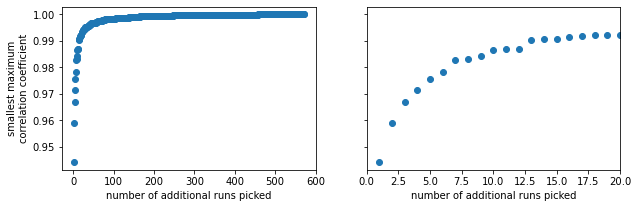

In [47]:
if refresh_2==False and read_in_sorted_pcc==False:
    print('PCC SORTING NOT PERFORMED.')
    
else:

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3), sharey=True)

    ax[0].scatter(np.arange(1,len(test_max_pcc)), test_max_pcc[1:])
    ax[0].set_xlabel('number of additional runs picked')
    ax[0].set_ylabel('smallest maximum\ncorrelation coefficient')

    ax[1].scatter(np.arange(1,len(test_max_pcc)), test_max_pcc[1:])
    ax[1].set_xlabel('number of additional runs picked')
    ax[1].set_xlim(0,20)

    plt.show(fig)

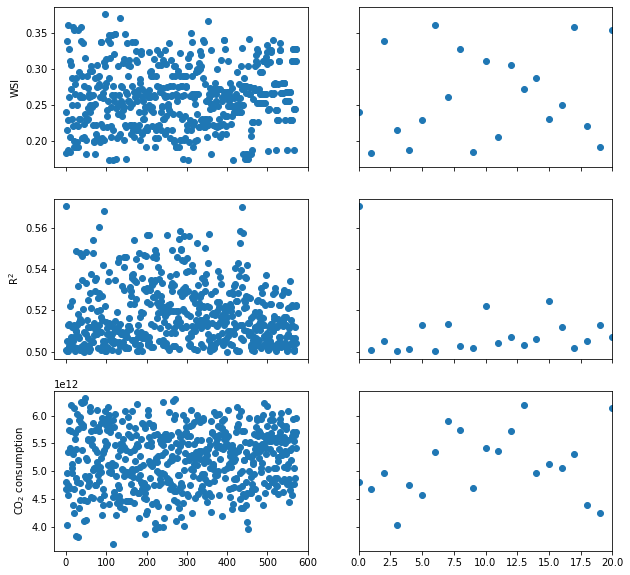

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='row', figsize=(10,10))

ax = ax.flatten()

ax[0].scatter(np.arange(len(test_ind)), params['WSI'][test_run_ID])
ax[0].set_ylabel('WSI')

ax[1].scatter(np.arange(len(test_ind)), params['WSI'][test_run_ID])
ax[1].set_xlim(0,20)

ax[2].scatter(np.arange(len(test_ind)), r2s[test_run_ID])
ax[2].set_ylabel('R$^{2}$')

ax[3].scatter(np.arange(len(test_ind)), r2s[test_run_ID])
ax[3].set_xlim(0,20)

ax[4].scatter(np.arange(len(test_ind)), total_CO2_consumption[test_run_ID])
ax[4].set_ylabel('CO$_{2}$ consumption')

ax[5].scatter(np.arange(len(test_ind)), total_CO2_consumption[test_run_ID])
ax[5].set_xlim(0,20)

plt.show(fig)

Output as a formatted dataframe:

In [49]:
test_Kwest = params['Kwest'][test_run_ID]
test_kw = params['kw'][test_run_ID]
test_sigma = params['sigma'][test_run_ID]
test_CaMg_1 = params['CaMg_1'][test_run_ID]
test_CaMg_2 = params['CaMg_2'][test_run_ID]
test_CaMg_3 = params['CaMg_3'][test_run_ID]
test_CaMg_4 = params['CaMg_4'][test_run_ID]
test_CaMg_5 = params['CaMg_5'][test_run_ID]
test_CaMg_6 = params['CaMg_6'][test_run_ID]
test_Ea = params['Ea'][test_run_ID]
test_T0 = params['T0'][test_run_ID]
test_krp = params['krp'][test_run_ID]
test_WSI = params['WSI'][test_run_ID]
test_total_CO2_consumption = total_CO2_consumption[test_run_ID]
test_r2s = r2s[test_run_ID]

test_df = pd.DataFrame({'ke':np.ones(len(test_run_ID))*0.0030713,
                        'a':np.ones(len(test_run_ID))*0.5,
                        'b':np.ones(len(test_run_ID))*1.0,
                        'krp':test_krp,
                        'Ea_rp':np.ones(len(test_run_ID))*42000.0,
                        'T0_rp':np.ones(len(test_run_ID))*286.0,
                        'h0':np.ones(len(test_run_ID))*2.73,
                        'kd':test_Kwest,
                        'kw':test_kw,
                        'Ea':test_Ea,
                        'T0':test_T0,
                        'sigma':test_sigma,
                        'CaMg_1':test_CaMg_1,
                        'CaMg_2':test_CaMg_2,
                        'CaMg_3':test_CaMg_3,
                        'CaMg_4':test_CaMg_4,
                        'CaMg_5':test_CaMg_5,
                        'CaMg_6':test_CaMg_6,
                        'R2':test_r2s})
test_df.reset_index(drop=True, inplace=True)
test_df.to_csv('../output/test_params.csv', index=False)
test_df.head()

,ke,a,b,krp,Ea_rp,T0_rp,h0,kd,kw,Ea,T0,sigma,CaMg_1,CaMg_2,CaMg_3,CaMg_4,CaMg_5,CaMg_6,R2
0,0.003071,0.5,1.0,0.010,42000.0,286.0,2.73,0.00050,1.00,42000.0,286.0,-0.4,2500.0,1521.0,4759.0,10317.0,0.0,2000.0,0.570428
1,0.003071,0.5,1.0,0.005,42000.0,286.0,2.73,0.00002,1.00,42000.0,286.0,-0.1,3500.0,1521.0,4759.0,10317.0,0.0,3000.0,0.500933
2,0.003071,0.5,1.0,0.015,42000.0,286.0,2.73,0.00001,0.50,42000.0,286.0,0.1,1500.0,1521.0,4759.0,10317.0,0.0,1000.0,0.505323
3,0.003071,0.5,1.0,0.015,42000.0,286.0,2.73,0.00002,1.00,42000.0,286.0,-0.1,3000.0,1521.0,4759.0,10317.0,0.0,1500.0,0.500235
4,0.003071,0.5,1.0,0.015,42000.0,286.0,2.73,0.01000,0.02,42000.0,286.0,-0.4,3500.0,1521.0,4759.0,10317.0,0.0,3000.0,0.501210


Make cross plots for the first 12 runs:

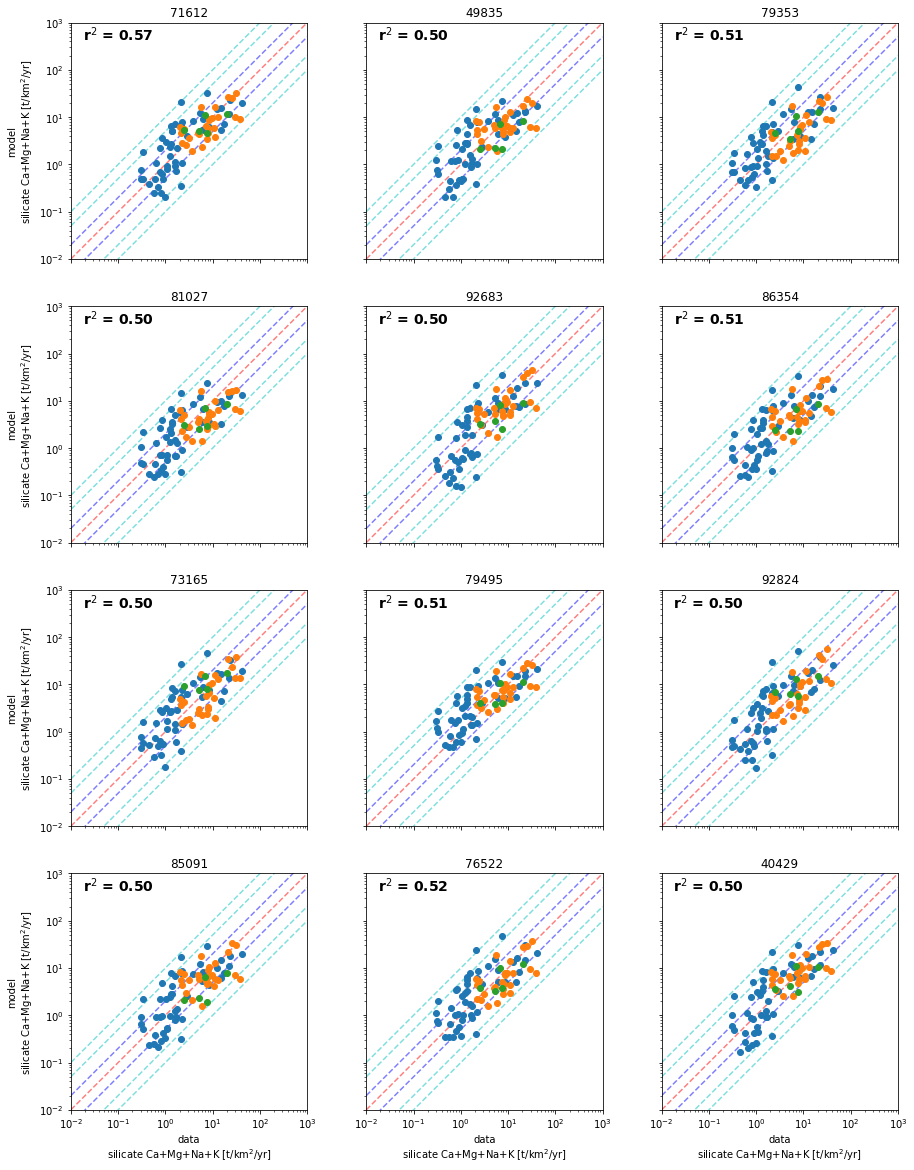

In [50]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,20), sharey=True)

ax = ax.flatten()

for i in range(12):
    log_cross_plot(basin_model.loc[test_run_ID[i]],
                   basin_data['CaMgNaK_sil_norm'],
                   basin_data['source'],
                   test_r2s[i],
                   ax[i],
                   legend=False, labels=False)
    ax[i].set_title(test_run_ID[i])
    
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
ax[3].set_xticklabels([])
ax[4].set_xticklabels([])
ax[5].set_xticklabels([])
ax[6].set_xticklabels([])
ax[7].set_xticklabels([])
ax[8].set_xticklabels([])

ax[9].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[10].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[11].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

ax[0].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[3].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[6].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[9].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
    
plt.show(fig)